<h1 style="text-align:center">训练时模型的保存和加载</h1>

[TOC]

## 实验介绍

本实验主要介绍使用MindSpore实现训练时模型的保存和加载。训练过程中保存模型以及训练中断后基于断点继续训练是一项非常常用的功能。建议先阅读MindSpore官网教程中关于模型参数保存和加载的内容。

## 实验目的

- 了解如何使用MindSpore实现训练时模型的保存。
- 了解如何使用MindSpore加载保存的模型文件并继续训练。
- 了解如何MindSpore的Callback功能。

## 预备知识

- 熟练使用Python，了解Shell及Linux操作系统基本知识。
- 具备一定的深度学习理论知识，如卷积神经网络、损失函数、优化器，训练策略、Checkpoint等。
- 了解华为云的基本使用方法，包括[OBS（对象存储）](https://www.huaweicloud.com/product/obs.html)、[ModelArts（AI开发平台）](https://www.huaweicloud.com/product/modelarts.html)、[Notebook（开发工具）](https://support.huaweicloud.com/engineers-modelarts/modelarts_23_0033.html)、[训练作业](https://support.huaweicloud.com/engineers-modelarts/modelarts_23_0046.html)等功能。华为云官网：https://www.huaweicloud.com
- 了解并熟悉MindSpore AI计算框架，MindSpore官网：https://www.mindspore.cn/

## 实验环境

- MindSpore 0.2.0（MindSpore版本会定期更新，本指导也会定期刷新，与版本配套）；
- 华为云ModelArts：ModelArts是华为云提供的面向开发者的一站式AI开发平台，集成了昇腾AI处理器资源池，用户可以在该平台下体验MindSpore。ModelArts官网：https://www.huaweicloud.com/product/modelarts.html

## 实验准备

### 创建OBS桶

本实验需要使用华为云OBS存储实验脚本和数据集，可以参考[快速通过OBS控制台上传下载文件](https://support.huaweicloud.com/qs-obs/obs_qs_0001.html)了解使用OBS创建桶、上传文件、下载文件的使用方法。

> **提示：**华为云新用户使用OBS时通常需要创建和配置“访问密钥”，可以在使用OBS时根据提示完成创建和配置。也可以参考[获取访问密钥并完成ModelArts全局配置](https://support.huaweicloud.com/prepare-modelarts/modelarts_08_0002.html)获取并配置访问密钥。

创建OBS桶的参考配置如下：

- 区域：华北-北京四
- 数据冗余存储策略：单AZ存储
- 桶名称：如ms-course
- 存储类别：标准存储
- 桶策略：公共读
- 归档数据直读：关闭
- 企业项目、标签等配置：免

### 数据集准备

MNIST是一个手写数字数据集，训练集包含60000张手写数字，测试集包含10000张手写数字，共10类。MNIST数据集的官网：[THE MNIST DATABASE](http://yann.lecun.com/exdb/mnist/)。

从MNIST官网下载如下4个文件到本地并解压：

```
train-images-idx3-ubyte.gz:  training set images (9912422 bytes)
train-labels-idx1-ubyte.gz:  training set labels (28881 bytes)
t10k-images-idx3-ubyte.gz:   test set images (1648877 bytes)
t10k-labels-idx1-ubyte.gz:   test set labels (4542 bytes)
```

### 脚本准备

从[课程gitee仓库](https://gitee.com/mindspore/course)上下载本实验相关脚本。

### 上传文件

将脚本和数据集上传到OBS桶中，组织为如下形式：

```
experiment_1
├── MNIST
│   ├── test
│   │   ├── t10k-images-idx3-ubyte
│   │   └── t10k-labels-idx1-ubyte
│   └── train
│       ├── train-images-idx3-ubyte
│       └── train-labels-idx1-ubyte
└── 脚本等文件
```

## 实验步骤（方案一）

### 创建Notebook

可以参考[创建并打开Notebook](https://support.huaweicloud.com/engineers-modelarts/modelarts_23_0034.html)来创建并打开本实验的Notebook脚本。

创建Notebook的参考配置：

- 计费模式：按需计费
- 名称：experiment_2
- 工作环境：Python3
- 资源池：公共资源
- 类型：Ascend
- 规格：单卡1*Ascend 910
- 存储位置：对象存储服务（OBS）->选择上述新建的OBS桶中的experiment_2文件夹
- 自动停止等配置：默认

> **注意：**
> - 打开Notebook前，在Jupyter Notebook文件列表页面，勾选目录里的所有文件/文件夹（实验脚本和数据集），并点击列表上方的“Sync OBS”按钮，使OBS桶中的所有文件同时同步到Notebook工作环境中，这样Notebook中的代码才能访问数据集。参考[使用Sync OBS功能](https://support.huaweicloud.com/engineers-modelarts/modelarts_23_0038.html)。
> - 打开Notebook后，选择MindSpore环境作为Kernel。

> **提示：**上述数据集和脚本的准备工作也可以在Notebook环境中完成，在Jupyter Notebook文件列表页面，点击右上角的"New"->"Terminal"，进入Notebook环境所在终端，进入`work`目录，可以使用常用的linux shell命令，如`wget, gzip, tar, mkdir, mv`等，完成数据集和脚本的下载和准备。

> **提示：**请从上至下阅读提示并执行代码框进行体验。代码框执行过程中左侧呈现[\*]，代码框执行完毕后左侧呈现如[1]，[2]等。请等上一个代码框执行完毕后再执行下一个代码框。

导入MindSpore模块和辅助模块：

In [3]:
import os
# os.environ['DEVICE_ID'] = '0'

import matplotlib.pyplot as plt
import numpy as np

import mindspore as ms
import mindspore.context as context
import mindspore.dataset.transforms.c_transforms as C
import mindspore.dataset.transforms.vision.c_transforms as CV

from mindspore.dataset.transforms.vision import Inter
from mindspore import nn, Tensor
from mindspore.train import Model
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor
from mindspore.train.serialization import load_checkpoint, load_param_into_net

import logging; logging.getLogger('matplotlib.font_manager').disabled = True

context.set_context(mode=context.GRAPH_MODE, device_target='Ascend')

### 数据处理

在使用数据集训练网络前，首先需要对数据进行预处理，如下：

In [4]:
DATA_DIR_TRAIN = "MNIST/train" # 训练集信息
DATA_DIR_TEST = "MNIST/test" # 测试集信息

def create_dataset(training=True, num_epoch=1, batch_size=32, resize=(32, 32),
                   rescale=1/(255*0.3081), shift=-0.1307/0.3081, buffer_size=64):
    ds = ms.dataset.MnistDataset(DATA_DIR_TRAIN if training else DATA_DIR_TEST)
    
    # define map operations
    resize_op = CV.Resize(resize)
    rescale_op = CV.Rescale(rescale, shift)
    hwc2chw_op = CV.HWC2CHW()
    
    # apply map operations on images
    ds = ds.map(input_columns="image", operations=[resize_op, rescale_op, hwc2chw_op])
    ds = ds.map(input_columns="label", operations=C.TypeCast(ms.int32))
    
    ds = ds.shuffle(buffer_size=buffer_size)
    ds = ds.batch(batch_size, drop_remainder=True)
    ds = ds.repeat(num_epoch)
    
    return ds

### 定义模型

定义LeNet5模型，模型结构如下图所示。

<img src="http://deeplearning.net/tutorial/_images/mylenet.png">
[1] 图片来源于http://deeplearning.net

In [5]:
class LeNet(nn.Cell):
    def __init__(self):
        super(LeNet, self).__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(1, 6, 5, stride=1, pad_mode='valid')
        self.conv2 = nn.Conv2d(6, 16, 5, stride=1, pad_mode='valid')
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Dense(400, 120)
        self.fc2 = nn.Dense(120, 84)
        self.fc3 = nn.Dense(84, 10)
    
    def construct(self, input_x):
        output = self.conv1(input_x)
        output = self.relu(output)
        output = self.pool(output)
        output = self.conv2(output)
        output = self.relu(output)
        output = self.pool(output)
        output = self.flatten(output)
        output = self.fc1(output)
        output = self.fc2(output)
        output = self.fc3(output)
        
        return output

### 保存模型Checkpoint

使用MNIST数据集对上述定义的LeNet5模型进行单机单卡训练，包含：

- 在MNIST数据集上训练模型。
- 通过`ModelCheckpoint`保存Checkpoint。
- 通过`LossMonitor`输出训练过程中的Loss。

Callback是模型训练/测试过程中的一种调试工具，可用在训练/测试过程中执行特定的任务。MindSpore框架提供的Callback：

- `ModelCheckpoint`：保存网络模型和参数，默认会保存最后一次训练的参数。
- `SummaryStep`：对Tensor值进行监控。此功能会在MindData平台训练脚本中使用。
- `LossMonitor`：监控loss值，当loss值为Nan或Inf时停止训练。此功能会在MindData平台训练脚本中使用。

`ModelCheckpoint`用于保存模型和参数，如每个epoch结束时，都保存一次checkpoint。

1. 首先需要初始化一个`CheckpointConfig`类对象，用以声明保存策略。调用方法如：
  
  ```py
  CheckpointConfig(save_checkpoint_steps=1, keep_checkpoint_max=5)
  ```
  
  参数说明：
  
  - `save_checkpoint_steps`：每多少step保存一个checkpoint文件，单位为step；
  - `keep_checkpoint_max`：最多保留checkpoint文件的数量（按最新的文件）。

2. 创建`ModelCheckpoint`对象。调用方法如：
  
  ```py
  ModelCheckpoint(prefix=DEFAULT_CHECKPOINT_PREFIX_NAME, config=None)
  ```
  
  参数说明：
  
  - `prefix`：保存的文件前缀名，如'ck_lenet'。
  - `config`：配置策略信息，传入上文创建的CheckpointConfig对象。

> `ModelCheckpoint`会生成和保存模型（.pkl）和Chekpoint（.ckpt）文件。

In [6]:
os.system('rm -f *.ckpt *.ir *.meta') # 清理旧的运行文件
LOOP_SINK = context.get_context('enable_loop_sink')

def test_train(lr=0.01, momentum=0.9, num_epoch=2, check_point_name="b_lenet"):
    ds_train = create_dataset(num_epoch=num_epoch)
    ds_eval = create_dataset(training=False)
    steps_per_epoch = ds_train.get_dataset_size()
    
    net = LeNet()
    loss = nn.loss.SoftmaxCrossEntropyWithLogits(is_grad=False, sparse=True, reduction='mean')
    opt = nn.Momentum(net.trainable_params(), lr, momentum)
    
    ckpt_cfg = CheckpointConfig(save_checkpoint_steps=steps_per_epoch, keep_checkpoint_max=5)
    ckpt_cb = ModelCheckpoint(prefix=check_point_name, config=ckpt_cfg)
    loss_cb = LossMonitor(per_print_times=1 if LOOP_SINK else steps_per_epoch)
    
    model = Model(net, loss, opt, metrics={'acc', 'loss'})
    model.train(num_epoch, ds_train, callbacks=[ckpt_cb, loss_cb], dataset_sink_mode=True)
    metrics = model.eval(ds_eval)
    print('Metrics:', metrics)

test_train()
print('\n'.join(sorted([x for x in os.listdir('.') if x.startswith('b_lenet')])))

epoch: 1 step: 1875 ,loss is 2.3151364
epoch: 2 step: 1875 ,loss is 0.3097728
Metrics: {'acc': 0.9417067307692307, 'loss': 0.18866610953894755}
b_lenet-1_1875.ckpt
b_lenet-2_1875.ckpt


### 加载Checkpoint继续训练

模型训练过程偶尔会中断，可以通过加载Checkpoint文件继续训练。

1. 读取Checkpoint文件，调用方法如：
  
  ```py
  load_checkpoint(ckpoint_file_name)
  ```
  
  参数说明：
  
  - `ckpoint_file_name`：checkpoint文件名，如'ck_lenet-7_1875.ckpt'。
  - 返回值：返回一个字典。key为参数name，value为parameter类型的实例。

2. 加载参数后继续训练，调用方法如：
  
  ```py
  load_param_into_net(net, param_dict)
  ```
  
  参数说明：
  
  - `net`：初始不带优化器和损失函数的网络，如：`Resnet()`。
  - `param_dict`：加载checkpoint文件后生成的字典。

> 使用load_checkpoint接口加载数据时，需要把数据传入给原始网络，而不能传递给带有优化器和损失函数的训练网络。

In [7]:
CKPT = 'b_lenet-2_1875.ckpt'

def resume_train(lr=0.001, momentum=0.9, num_epoch=2, ckpt_name="b_lenet"):
    ds_train = create_dataset(num_epoch=num_epoch)
    ds_eval = create_dataset(training=False)
    steps_per_epoch = ds_train.get_dataset_size()
    
    net = LeNet()
    loss = nn.loss.SoftmaxCrossEntropyWithLogits(is_grad=False, sparse=True, reduction='mean')
    opt = nn.Momentum(net.trainable_params(), lr, momentum)
    
    param_dict = load_checkpoint(CKPT)
    load_param_into_net(net, param_dict)
    load_param_into_net(opt, param_dict)
    
    ckpt_cfg = CheckpointConfig(save_checkpoint_steps=steps_per_epoch, keep_checkpoint_max=5)
    ckpt_cb = ModelCheckpoint(prefix=ckpt_name, config=ckpt_cfg)
    loss_cb = LossMonitor(per_print_times=1 if LOOP_SINK else steps_per_epoch)
    
    model = Model(net, loss, opt, metrics={'acc', 'loss'})
    model.train(num_epoch, ds_train, callbacks=[ckpt_cb, loss_cb])
    
    metrics = model.eval(ds_eval)
    print('Metrics:', metrics)

resume_train()
print('\n'.join(sorted([x for x in os.listdir('.') if x.startswith('b_lenet')])))

epoch: 1 step: 1875 ,loss is 0.1638589
epoch: 2 step: 1875 ,loss is 0.060048036
Metrics: {'acc': 0.9742588141025641, 'loss': 0.07910804035148034}
b_lenet_1-1_1875.ckpt
b_lenet_1-2_1875.ckpt


### 推理

加载Checkpoint，并执行验证。读取模型和Checkpoint文件，调用方法如：
  
  ```py
  load(model_file_name, ckpoint_file_name)
  ```
  
  参数说明：
  
  - `model_file_name`：模型文件名，如'ck_lenet-model.pkl'。
  - `ckpoint_file_name`：checkpoint文件名，如'ck_lenet-7_1875.ckpt'。
  
使用matplotlib定义一个将推理结果可视化的辅助函数，如下：

In [8]:
def plot_images(pred_fn, ds, net):
    for i in range(1, 5):
        pred, image, label = pred_fn(ds, net)
        plt.subplot(2, 2, i)
        plt.imshow(np.squeeze(image))
        color = 'blue' if pred == label else 'red'
        plt.title("prediction: {}, truth: {}".format(pred, label), color=color)
        plt.xticks([])
    plt.show()

使用训练后的LeNet模型对手写数字进行识别，可以看到识别结果基本上是正确的。

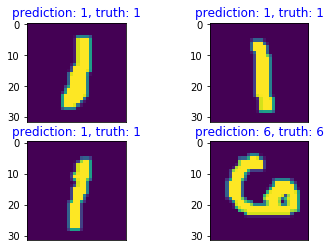

In [9]:
CKPT = 'b_lenet_1-2_1875.ckpt'

def infer(ds, model):
    data = ds.get_next()
    images = data['image']
    labels = data['label']
    output = model.predict(Tensor(data['image']))
    pred = np.argmax(output.asnumpy(), axis=1)
    return pred[0], images[0], labels[0]

ds = create_dataset(training=False, batch_size=1).create_dict_iterator()
net = LeNet()
param_dict = load_checkpoint(CKPT)
load_param_into_net(net, param_dict)
model = Model(net)
plot_images(infer, ds, model)

## 实验步骤（方案二）

### 代码梳理

创建训练作业时，运行参数会通过脚本传参的方式输入给脚本代码，脚本必须解析传参才能在代码中使用相应参数。如data_url和train_url，分别对应数据存储路径(OBS路径)和训练输出路径(OBS路径)。脚本对传参进行解析后赋值到`args`变量里，在后续代码里可以使用。

```python
import argparse
parser = argparse.ArgumentParser()
parser.add_argument('--data_url', required=True, default=None, help='Location of data.')
parser.add_argument('--train_url', required=True, default=None, help='Location of training outputs.')
parser.add_argument('--num_epochs', type=int, default=1, help='Number of training epochs.')
args, unknown = parser.parse_known_args()
```

MindSpore暂时没有提供直接访问OBS数据的接口，需要通过MoXing提供的API与OBS交互。将OBS中存储的数据拷贝至执行容器：

```python
import moxing as mox
mox.file.copy_parallel(src_url=args.data_url, dst_url='MNIST/')
```

如需将训练输出（如模型Checkpoint）从执行容器拷贝至OBS，请参考：

```python
import moxing as mox
mox.file.copy_parallel(src_url='output', dst_url='s3://OBS/PATH')
```

其他代码分析请参考方案一。

### 创建训练作业

可以参考[使用常用框架训练模型](https://support.huaweicloud.com/engineers-modelarts/modelarts_23_0238.html)来创建并启动训练作业。

创建训练作业的参考配置：

- 算法来源：常用框架->Ascend-Powered-Engine->MindSpore
- 代码目录：选择上述新建的OBS桶中的experiment_2目录
- 启动文件：选择上述新建的OBS桶中的experiment_2目录下的`main.py`
- 数据来源：数据存储位置->选择上述新建的OBS桶中的experiment_1文件夹下的MNIST目录
- 训练输出位置：选择上述新建的OBS桶中的experiment_1目录并在其中创建output目录
- 作业日志路径：同训练输出位置
- 规格：Ascend:1*Ascend 910
- 其他均为默认

启动并查看训练过程：

1. 点击提交以开始训练；
2. 在训练作业列表里可以看到刚创建的训练作业，在训练作业页面可以看到版本管理；
3. 点击运行中的训练作业，在展开的窗口中可以查看作业配置信息，以及训练过程中的日志，日志会不断刷新，等训练作业完成后也可以下载日志到本地进行查看；
4. 在训练日志中可以看到`epoch: 3 step: 1875 ,loss is 0.025683485`等字段，即训练过程的loss值；
5. 在训练日志中可以看到`Metrics: {'acc': 0.9742588141025641, 'loss': 0.08628832848253062}`等字段，即训练完成后的验证精度；
6. 在训练日志里可以看到`b_lenet_1-2_1875.ckpt`等字段，即训练过程保存的Checkpoint。

## 实验小结

本实验展示了MindSpore的Checkpoint、断点继续训练等高级特性：
1. 使用MindSpore的ModelCheckpoint接口每个epoch保存一次Checkpoint，训练2个epoch并终止。
2. 使用MindSpore的load_checkpoint和load_param_into_net接口加载上一步保存的Checkpoint继续训练2个epoch。
3. 观察训练过程中Loss的变化情况，加载Checkpoint继续训练后loss进一步下降。